# ECON622: Assignment 6

# Packages

Add whatever packages you want!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import torch
import jax
import jax.numpy as jnp
from jax import grad, hessian
import torch
import torch.nn as nn
import torch.optim as optim
from flax import nnx

# Question 1

In the repository you have code with does a linear regression with
Pytorch `linear_regression_pytorch_lightning.py`.

## Question 1.1

Make a new file that does the same thing, but replace the
`nn.Linear(M, 1, bias=False)` with code that gives a neural network with
multiple layers. Maybe try

In [2]:
M = 2 # loaded automatically in the code
num_width = 8 # etc.  You can hardcode or add to the template/yaml code
nn.Sequential(
    nn.Linear(M, num_width),
    nn.ReLU(),
    nn.Linear(num_width, 1, bias = False)
)

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=False)
)

This is a network with one “hidden” layer Try this for a very shallow
network (e.g. `num_width = 8`) and see if it converges with Adam or SGD.
It is OK if it does not! Don’t spend too much time with it.

## Question 1.2

Now replace this with a deeper and wider network by the same pattern.
Maybe something like

In [3]:
M = 2 # loaded automatically in the code
num_width = 256 # etc.  You can hardcode or add to the template/yaml code
nn.Sequential(
    nn.Linear(M, num_width),
    nn.ReLU(),
    nn.Linear(num_width, num_width),
    nn.ReLU(),
    nn.Linear(num_width, num_width),
    nn.ReLU(),
    nn.Linear(num_width, num_width),
    nn.ReLU(),
    nn.Linear(num_width, 1, bias = False)
)

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=1, bias=False)
)

Try to optimize this now and see if it fits well with this deeper
network. If this is too slow, change the `num_width` or remove a layer
to see if it helps.

## Question 1.3 (BONUS)

The above is trying to fit a linear DGP. Instead, increase the dimenson
`M` to something much larger, and modify the DGP to be something
nonlinear. Try out the larger network to see if it fits it well.

# Question 2

Now we can try the same thing JAX and NNX titled
`linear_regression_jax_nnx.py`

## Question 2.1

Take the code and modify the network from the simple
`nnx.Linear(M, 1, use_bias=False, rngs=rngs)` to do a nonlinear function
with more parameters and layers, as in Question 1.2.

There is no builtin MLP in `nnx`, but you can construct it manually by
creating a class from `nnx.Module` and then nesting calls to
`nnx.Linear` with an “activaiton” like `nnx.relu` functions. See [the
docs](https://flax.readthedocs.io/en/latest/mnist_tutorial.html#define-the-model-with-flax-nnx)
for more information.

## Question 3

The following code comes from
[GPyTorch](https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html)
documentation.

Iter 1/50 - Loss: 0.948   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.918   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.885   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.847   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.805   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.756   lengthscale: 0.476   noise: 0.474
Iter 7/50 - Loss: 0.704   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.651   lengthscale: 0.405   noise: 0.402
Iter 9/50 - Loss: 0.599   lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.552   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.509   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.470   lengthscale: 0.291   noise: 0.284
Iter 13/50 - Loss: 0.434   lengthscale: 0.271   noise: 0.259
Iter 14/50 - Loss: 0.400   lengthscale: 0.254   noise: 0.236
Iter 15/50 - Loss: 0.367   lengthscale: 0.240   noise: 0.215
Iter 16/50 - Loss: 0.334   lengthscale: 0.229   noise: 0.196
Iter 17/50 - Loss: 0.302   length

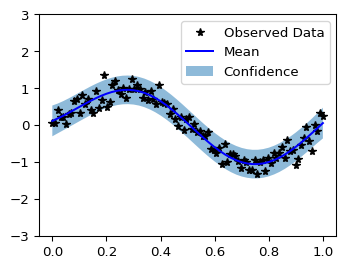

In [4]:
import math
import torch
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel, LinearKernel
from matplotlib import pyplot as plt
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])    

## Question 3.1

Using the code above, try a different kernel from [the
docs](https://docs.gpytorch.ai/en/stable/kernels.html) and plot the
results. Doesn’t matter if it is better or worse, but you should try to
pick a kernel that has different parameters to fit.

## Question 3.2 (BONUS)

Now take the code above:

1.  Remove the noise in DGP
2.  Decrease the number of generated datapoints to maybe 10 or so.
3.  Try to see how to fit a GP without any observational noise, so that
    it interpolates the data. This may require changing the likelihood
    object in the loop above.